# ex12

In [1]:
! pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.2 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=50504c4c5b281f233dc7f051dcc99158c232db54791c7efcd81c117b92a89359
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [2]:
! pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


버전 때문에 , import importlib_metadata as metadata라고 고쳐줬다.

In [4]:
import importlib_metadata as metadata
import nltk
import tensorflow
import summa
import pandas as pd
import urllib.request

print(nltk.__version__)
print(tensorflow.__version__)
print(metadata.version('summa'))

3.7
2.8.2
1.2.0


In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
data.sample(10)

,headlines,text
79655,"Malaysia bans Despacito on govt radio, TV over...",Malaysia has banned playing the song Despacito...
54955,French journo held for filming in Kashmir disc...,A French journalist who was arrested in Kashmi...
98133,La La Land actor Ryan Gosling features on cove...,"Hollywood actor Ryan Gosling, who starred in O..."
36784,Bumrah doesn't understand what pressure is: MI...,"Speaking about pacer Jasprit Bumrah, Mumbai In..."
981,"Unable to pay informants, says FBI amid US gov...",The US' Federal Bureau of Investigation is not...
76832,I am happy to be under my husband Ajay's shado...,Kajol has said that she is happy to be under h...
96871,Bihar police doesn't require 'anti-Romeo' squa...,Commenting on the newly-elected Uttar Pradesh ...
91108,It's girl love homage: Priyanka on Katrina lin...,Actress Priyanka Chopra has said that the 'Cha...
97120,"UP minister seen sweeping office, corridor wit...",Uttar Pradesh cabinet minister Upendra Tiwari ...
12745,Salman encouraged me to do 'Radha Kyon Gori Ma...,"Iulia Vantur, who will be making her Bollywood..."


이 데이터는 기사의 본문에 해당하는 text와 headlines 두가지 열로 구성되어 있다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다.

추출적 요약을 하는 경우에는 오직 text열만을 사용한다.

### 추상적요약

#### 데이터 전처리

In [7]:
print(data['text'].shape)
print(data['headlines'].shape)
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

(98401,)
(98401,)
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


약 100개 정도가 겹친다는 것을 알 수 있다. 요약은 같을 수 있지만, text가 겹친다는 것은 샘플이 겹친다는 의미이므로 삭제해줘야 한다.

In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


잘 삭제되었다는 것을 알 수 있다.

이제 널값을 확인하고 삭제를 해줘야 한다. 널값을 삭제할 때는 dropna 명령어를 쓰면 된다.

data.dropna(axis=0, inplace=True)

In [9]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


데이터에 널값이 없다는 것을 확이했다. 다음 전처리 스텝으로 넘어가면 되겠다.

이번에는 동의어를 가진 모양이 비슷한 단어들을 하나로 만들어 줄 것이다.

예를 들어, it'll, it will과 같고, mustn't와 must not은 사실 같은 표현이다.

컴퓨터틑 이 둘을 다르다고 인식하면서 학습을 할 것이다. 하지만, 사실 같은 표현이다. 연산량을 늘어나게 할 뿐이다. 그래서 처리 속도를 빠르게 하기 위해 이와 같은 표현을  하나로 인식하게 만들어줘야 한다.

이제, 우리는 이미 만들어진 정규화를 위한 사전(dictionary)을 구성해 볼 것이다.

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


이번에는 불용어를 지워줄 것이다.

불용어란? 인터넷 검색 시 검색 용어로 사용하지 않는 단어. 관사, 전치사, 조사, 접속사 등은 검색 색인 단어로 의미가 없는 단어이다. 그러나, 각 검색 엔진마다 그 내용은 다를 수도 있다.

여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 것이다.

Nltk를 명령어를 쓰기 위해, 필요한 키워드를 다운 받아야 한다.

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
from nltk.corpus import stopwords
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

불용어가 179개인 것을 확인할 수 있다. 이를 이용해 삭제할 것이다.

그리고 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 것이다.

In [13]:
# 데이터 전처리 함수
from bs4 import BeautifulSoup
import re

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

if문을 자세히 보면, texts에만 불용어를 삭제해준다는 것을 알 수 있다. 왜냐하면, headlines에서는 요약문이 들어가는데, 이 때 요약문에 불용어가 들어갈 수 있기 때문이다. 요약문에서는 불용어 즉, 축약형이 더 알맞아 보이는 경우가 있을 수 있다.

In [14]:
# 잘 변형되었는 지 확인해 보자.
temp_text = 'A 28-year-old woman has accused Uttar Pradesh BJP MLA Roshan Lal Verma and his son Manoj of raping her in 2011 and getting her married to his younger son Vinod. She also alleged that Vinod left her and their daughter after police closed the case against Roshan in 2013. She staged a day-long protest at Shahjahanpur collectorate demanding their arrest.'
temp_summary = '	Woman claims MLA, son raped her; married her to 2nd son'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  year old woman accused uttar pradesh bjp mla roshan lal verma son manoj raping getting married younger son vinod also alleged vinod left daughter police closed case roshan staged day long protest shahjahanpur collectorate demanding arrest
summary: woman claims mla son raped her married her to nd son


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었다. (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다. 또한 특수문자가 제거되면서 영어만 남아있다.



전처리를 진행하면, 예기치 못하게 널값이 생기는 경우가 있다. 이를 먼저 확인해보고, 있다면 삭제해야 한다.

In [15]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


이제 전처리를 위한 셋팅은 끝났다. 이제, 훈련 데이터에 이를 적용시켜 보자.

In [16]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [17]:
# 불용어 제거를 막기위해, False를 줌
clean_summary = []
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


위와 같이 전처리를 하면, 모든 단어가 지워져서 빈 칸이 있을 것이다. 이를 확인하고, 널값으로 만들어 준 다음 삭제시키자.

In [18]:
import numpy as np
data['test'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
test         0
dtype: int64

널 값이 없다는 것을 확인할 수 있었다. 그러면 이제 본격적인 모델링에 앞서 훈련데이터와 테스트데이터로 나눠보자.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


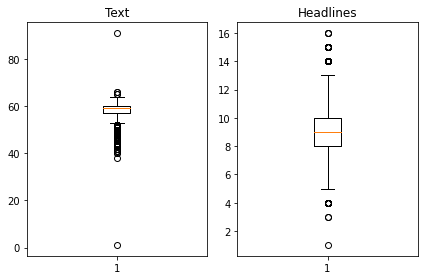

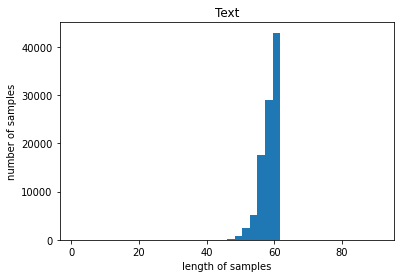

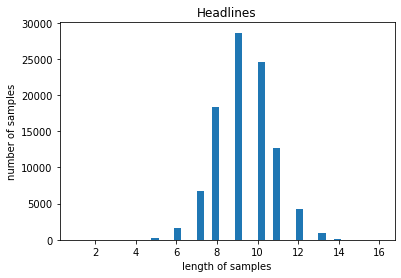

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

노드에서는 평균 길이를 사용했다.

하지만, 나는 최고 길이를 사용해야 좀 더 좋은 값을 얻을 거라 생각한다. 어차피 길이 짧은 값들은 0으로 패딩을 하면 되고, 길이가 긴 문장을 짧은 문장으로 강제로 줄이게 되면 아예 다른 뜻으로 바뀔 수 있다는 생각 때문이다.

그래서, 최대길이를 사용해보겠다.

In [20]:
text_max_len = 91
headlines_max_len = 16

얼마나 많은 샘플들을 자르지 않고 포함할 수 있을지 통계로 확인해보자.

In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 91 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


역시 최대 길이를 설정하니, 모든 데이터가 편집 없이 원본 데이터를 쓸 수 있다고 나온다.

위에서 언급했 듯이, 데이터가 수정되면 원래의 뜻과 달라질 수 있다. 그래서, 의도한 바와 다르게 요약될 수 있다. 이런 오류를 줄이기 위해서,해당 길이보다 긴 샘플들을 훈련 데이터에서 삭제되게 만들어줘야 한다.
                    

```
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))
```



디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춘다. 

그리고 훈련을 하기 위해, numpy로 바꿔줘야 한다.

In [25]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [35]:
from sklearn.model_selection import train_test_split
encoder_input_train, encoder_input_test = train_test_split(encoder_input,test_size=0.2, random_state=42)
decoder_input_train, decoder_input_test = train_test_split(decoder_input,test_size=0.2, random_state=42)
decoder_target_train, decoder_target_test = train_test_split(decoder_target,test_size=0.2, random_state=42)
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다. 이 과정을 단어 집합(vocabulary)을 만든다고 표현한다. 훈련 데이터에 대해서 단어 집합을 만들어 보겠다.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [38]:
from keras.preprocessing.text import Tokenizer
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있다. 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 한다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는 지 확인해보겠다.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어보자.

In [42]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 91208
등장 빈도가 5번 이하인 희귀 단어의 수: 64230
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 26978
단어 집합에서 희귀 단어의 비율: 70.42145425839838
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.4406697412855536


등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상 차지 but 등장 빈도로 차지하는 비중은 3%대라 삭제하겠다.

vocab이 빈도수가 제일 많은 값부터 위에서 아래로 오름차순으로 정렬되어 있다. 그래서 전체 집합을 숫자를 줄이면, 빈도수가 낮아지는 것이 줄어들게 된다.

In [43]:
src_vocab = 27000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 27,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [44]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2531, 478, 58, 7249, 7698, 7, 134, 3227, 253, 671, 162, 1151, 1543, 559, 3, 1968, 232, 14, 184, 6068, 2712, 954, 4, 21, 7698, 762, 1151, 1543, 559, 64, 17, 504, 2, 13584, 199, 1, 55, 601, 3517, 3456, 671, 1894, 6, 1175, 14501, 5, 2832, 7, 1, 671, 3961, 35, 122, 509, 5, 1151, 1543, 6069, 480, 16, 41, 60, 206, 136], [49, 892, 4, 9053, 399, 26, 456, 16799, 4, 4307, 8233, 6, 1066, 50, 47, 10808, 3497, 89, 4702, 28, 4226, 6387, 6, 581, 9, 276, 9053, 8, 3, 1389, 53, 1825, 1857, 2596, 2807, 15, 3497, 193, 5, 2353, 44, 6, 28, 44, 1665, 2, 1529, 1263, 4346, 1, 49, 10], [1121, 336, 250, 74, 239, 19, 8496, 2759, 26, 10599, 1, 5079, 5, 3, 101, 7, 1730, 628, 8497, 20, 132, 375, 1398, 634, 6, 1815, 1406, 26979, 10196, 2935, 1, 4463, 6388, 425, 1, 5578, 31, 3751, 2, 14023, 425, 8497, 2284, 1, 239, 12, 4250, 15, 6970, 3, 5194, 4, 22999, 6, 2, 3209, 1, 6735]]


In [45]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [48]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30083
등장 빈도가 3번 이하인 희귀 단어의 수: 16943
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13140
단어 집합에서 희귀 단어의 비율: 56.32084566033973
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.156553508830357


In [49]:
tar_vocab = 13200
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 153, 1614, 357, 114, 676, 1057, 173, 2275, 5, 4530], [1, 86, 63, 4531, 6, 11582, 4842, 4, 6828, 3042], [1, 291, 11583, 6, 123, 2631, 52, 638, 81, 4286], [1, 45, 3186, 3503, 7642, 7, 3584, 182, 3, 10357, 911], [1, 540, 949, 657, 1884, 1255, 2982, 3, 1819, 22]]
target
decoder  [[153, 1614, 357, 114, 676, 1057, 173, 2275, 5, 4530, 2], [86, 63, 4531, 6, 11582, 4842, 4, 6828, 3042, 2], [291, 11583, 6, 123, 2631, 52, 638, 81, 4286, 2], [45, 3186, 3503, 7642, 7, 3584, 182, 3, 10357, 911, 2], [540, 949, 657, 1884, 1255, 2982, 3, 1819, 22, 2]]


전처리를 통해, 문장이 아예 없어질 수도 있다. 있는 지 확인하고, 삭제해줘야 한다.

In [50]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


길이가 다르기 때문에, modeling을 할 수 없다. 그래서, padding을 해줘서 사이즈를 맞춰줘야 한다.

In [55]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

#### 모델링

In [56]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [57]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [58]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 91)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 91, 128)      3456000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 91, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

여기까지가 제일 기본적인, seq2seq의 기본 구조이다. 하지만, 이러한 방식으로는 만족하는 결과치를 볼 수 없다. 

조금 더, 성능을 업그레이드 하기 위해서, 어텐션 메커니즘을 사용해야 한다.

In [59]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 91)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 91, 128)      3456000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 91, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [60]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 55s 143ms/step - loss: 4.4659 - val_loss: 4.1171
Epoch 2/50
308/308 [==============================] - 43s 138ms/step - loss: 3.9991 - val_loss: 3.8076
Epoch 3/50
308/308 [==============================] - 43s 138ms/step - loss: 3.7168 - val_loss: 3.5944
Epoch 4/50
308/308 [==============================] - 43s 138ms/step - loss: 3.5178 - val_loss: 3.4522
Epoch 5/50
308/308 [==============================] - 43s 139ms/step - loss: 3.3644 - val_loss: 3.3480
Epoch 6/50
308/308 [==============================] - 43s 138ms/step - loss: 3.2319 - val_loss: 3.2577
Epoch 7/50
308/308 [==============================] - 43s 139ms/step - loss: 3.1150 - val_loss: 3.1868
Epoch 8/50
308/308 [==============================] - 43s 138ms/step - loss: 3.0131 - val_loss: 3.1352
Epoch 9/50
308/308 [==============================] - 43s 139ms/step - loss: 2.9254 - val_loss: 3.0815
Epoch 10/50
308/308 [==============================] - 43s 139ms/step - l

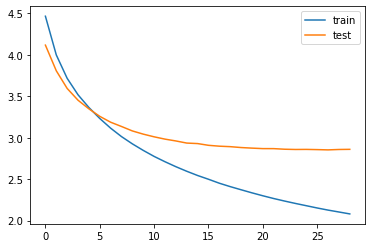

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



```
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
```
val_loss(검증 데이터의 손실) 손실이 줄어들지 않고 증가하는 현상이 2회 과측되면 학습을 멈추도록 설정했다.

이 때는, 28~29까지 줄어들지 않아 멈췄다. 


#### 결과 : 실제 결과와 요약문 비교하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 한다.

이 때 필요한 3개의 사전을 만들어야 한다.

In [62]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

전체적인 번역 동작 단계를 정리하면 아래와 같습니다.
1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉 상태와 셀 상태를 얻습니다.
2. 상태와 <SOS>에 해당하는 '\t'를 디코더로 보냅니다.
3. 디코더가 <EOS>에 해당하는 '\n'이 나올 때까지 다음 문자를 예측하는 행동을 반복합니다.

In [71]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계

In [72]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 시퀀스를 완성하는 함수

In [73]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [74]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [70]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : tony the french referee who kicked out at a footballer before sending him off during a ligue 1 game was handed a three month ban with a further three months suspended ban by the ligue 1 had apologised for his actions the following day of the incident and called his own reaction clumsy and inappropriate 
실제 요약 : french referee who kicked footballer banned for months 
예측 요약 :  player gets off player for not referee for match


원문 : after priyanka gandhi vadra entered active politics sad chief sukhbir singh badal said i think they are training her so that when congress president rahul gandhi will fail they can bring in priyanka gandhi he added this is all drama and their media strategy it will not make any difference at ground level 
실제 요약 : congress training priyanka to take over when rahul fails sad 
예측 요약 :  rahul gandhi is not the politics of politics bjp


원문 : on the occasion of his country's independence day pakistani pm shahid abbasi on monday urged the international communit

전반적으로 중요하게 사용된 단어들을 추출하여 요약을 했다. 하지만, 문맥이 말하고 있는 내용을 내포하고 있지 않다.

즉, 원문에서 많이 쓰는 단어들을 잘 가지고는 오지만, 상황까지 파악을 하진 못하고 있다.

### 추출적 요약

In [89]:
import requests
from summa.summarizer import summarize

In [90]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [91]:
print(data[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

In [103]:
for i in range(50, 100):
  print('{}번 째 문장'.format(i-49), data['text'][i])
  print('추출적 요약 :',summarize(data['text'][i], ratio=0.4))
  print()

1번 째 문장 Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
추출적 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).

2번 째 문장 US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018. 
추출적 요약 : Boeing retained i

확실히 추상적보다, 추출이 더 정확성이 높은 거 같다.

### 회고

참고

https://wikidocs.net/24996

RNN 정말 재밌는 분야 같다. 확률로 예측을 하고 새로운 결과를 뽑아내는 재미가 쏠쏠하다.

전반적으로 RNN 개념을 잘 이해한 거 같다. 심화학습인 req2req도 전체 메커니즘은 이해를 하고 프로젝트를 완성을 했다. 하지만 의문점이 하나 남아있다. 모델 테스트 할 때, 인코더를 왜 재 정립을 해야하는 지 의문이다. 메커니즘 상 디코더에서만 변화가 일어나서, 이 부분만 수정하면 되지 않나 싶었다. 구글링 결과도 나와 같은 생각을 말해주고 있다. 노드에서 따른 의도가 있는 것인지 궁금하다.

날이 갈수록 NLP가 재밌는 거 같다. 이제 선택해야 하는 순간이 바로 코 앞인데 무엇을 골라야 할 지...